# TODO:

- remove unnecessary imports
- compare FIMP rankings 
- remove 'temporary' stuff
- add interpretable pdf cells
- produce word cloud and pdf figures for manuscript

## Interpretability outputs

Here we compare a number of standard interpretability methods and use them to produce bespoke visualisations. We choose to focus on the RF classifier, but this approach (other the use of TreeInterpreter) could be used with any classifier algorithm. 

To run this script please first run 'fitting_classifiers.ipynb' to train optimised SVC, LR, RF. This script uses those pre-trained joblib models.

In [1]:
DATA_DIR = "../data/"   
DATA = "CAP"
CLASS_LABEL = 'pca_death_code'  # Target label to predict

RANDOM_STATE = 42
TEST_SIZE = 0.2
CV = 5

DEMO_INSTANCE = 64

In [2]:
import shap
import numpy as np
import pandas as pd
import pickle
from joblib import dump, load
from collections import Counter
from scipy.stats import spearmanr

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

from helper import (pd_print, 
                    accuracy,
                    lemmatize_text,
                    summarise_gridsearch_classifier,
                    calibrate_random_forest, 
                    plot_calibration_curve,
                    plot_calibration_curve_easy_hard,
                    plot_roc_curve,
                    compute_all_metrics)

from explainability import (get_rf_feature_importances,
                            wordcloud,
                            run_tree_interpreter,
                            get_ti_feature_contributions_for_instance_i,
                            get_ti_feature_contributions_average,
                            get_lime_explanation_average,
                            get_lime_explanation_instance,
                            get_shap_value_average,
                            get_shap_values)

from cap_helper import *
from interpretable_pdf import InterpretablePDF

21-Jan-30 08:33:19 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.
21-Jan-30 08:33:19 fatf         INFO     Seeding RNGs using the input parameter.
21-Jan-30 08:33:19 fatf         INFO     Seeding RNGs with 42.


In [3]:
print("Loading CAP prostate cancer data for preprocessing.")
df = load_data(DATA_DIR)
# Combine text from all feature columns into a single string column
df = concatenate_feature_columns(df)
# Link to dates of death:
df = add_dates(df, DATA_DIR)
# Link to reviewer Ids:
df = add_reviewer_ids(df, DATA_DIR)
# Convert all dates to be in units of months before/after death (Note: this regex is not foolproof)
df = convert_dates_relative(df)  

print("Preprocessing complete.")

Loading CAP prostate cancer data for preprocessing.
Preprocessing complete.


In [4]:
stemmer = WordNetLemmatizer()
X,y = df.combined, df[CLASS_LABEL]
documents = lemmatize_text(X, stemmer)
X_train, X_test, y_train, y_test = train_test_split(documents, 
                                                    df[CLASS_LABEL], 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [5]:
clf = load('models/cap_rf_gridsearch.joblib')

In [6]:
fimps = get_rf_feature_importances(clf)
assert fimps.feature.is_unique
fimps.head(15)

,feature,contribution,magnitude,rank_rf
657,hormone,0.030726,0.030726,0
299,bone scan,0.027834,0.027834,1
1282,spine,0.024761,0.024761,2
1483,widespread,0.023501,0.023501,3
212,androgen,0.022829,0.022829,4
495,docetaxel,0.021184,0.021184,5
1208,sclerotic,0.019898,0.019898,6
1198,scan,0.019604,0.019604,7
213,androgen blockade,0.019216,0.019216,8
288,blockade,0.017032,0.017032,9


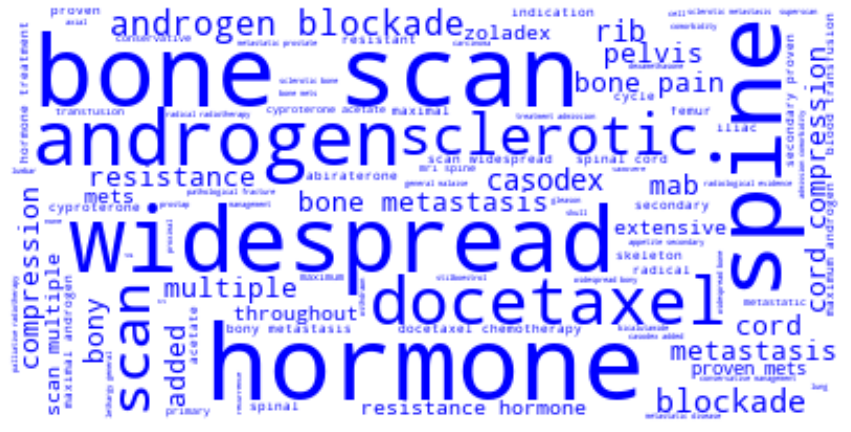

In [7]:
wordcloud(fimps)

In [8]:
prediction, bias, contributions = run_tree_interpreter(clf, X_train)
fimps_ti_i = get_ti_feature_contributions_for_instance_i(DEMO_INSTANCE, contributions, clf)

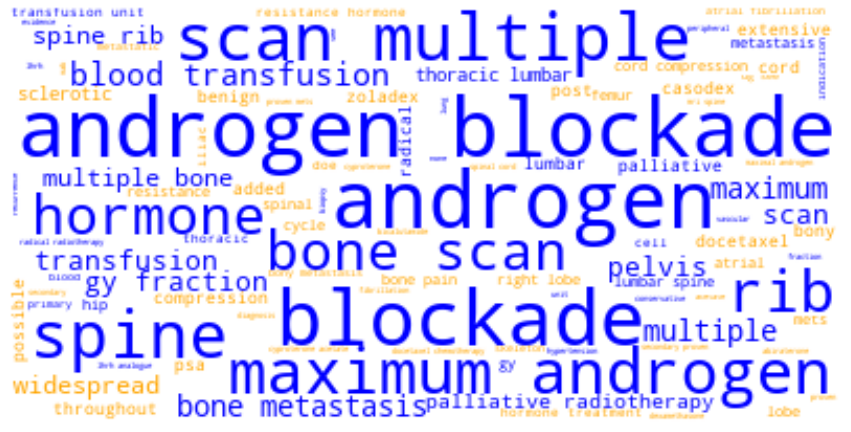

In [9]:
wordcloud(fimps_ti_i)

In [10]:
fimps_ti = get_ti_feature_contributions_average(contributions, clf)

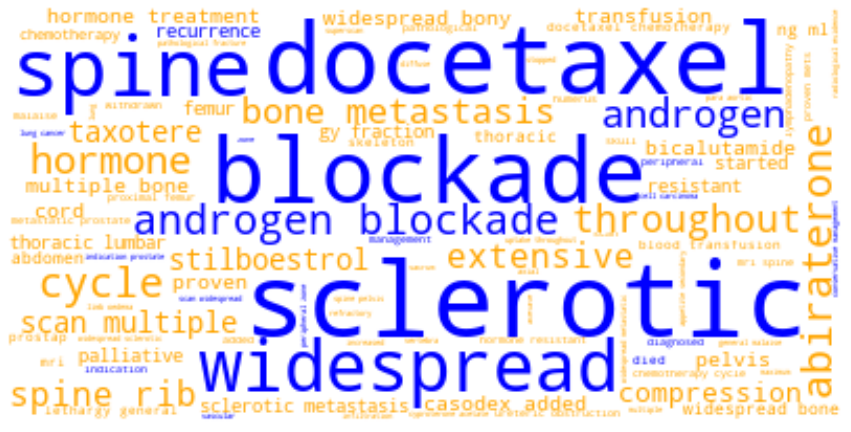

In [11]:
wordcloud(fimps_ti)

#### Using LIME:

In [12]:
fimps_lime_i = get_lime_explanation_instance(clf, documents, DEMO_INSTANCE);

21-Jan-30 08:37:35 fatf.transparency.predictions.surrogate_explainers INFO     Selecting 1500 features with highest weights.


In [13]:
#fimps_lime = get_lime_explanation_average(clf, documents, 42);
#fimps_lime.to_pickle('fimps_lime_av.pickle')

In [14]:
with open('fimps_lime_av.pickle', 'rb') as ifile:
    fimps_lime = pickle.load(ifile)

#### Now we use SHAP to evaluate feature importances:

In [ ]:
fimps_shap = get_shap_value_average(clf, documents)

In [ ]:
wordcloud(fimps_shap)

In [ ]:
merged = fimps_lime.merge(fimps_shap, on='feature')
spearmanr(merged.rank_lime, merged.rank_shap)

In [ ]:
merged = fimps_lime.merge(fimps_ti, on='feature')
spearmanr(merged.rank_lime, merged.rank_ti)

In [ ]:
merged = fimps_lime.merge(fimps, on='feature')
spearmanr(merged.rank_lime, merged.rank_rf)

In [ ]:
merged = fimps_ti.merge(fimps, on='feature')
spearmanr(merged.rank_rf, merged.rank_ti)

In [ ]:
merged = fimps_ti.merge(fimps_shap, on='feature')
spearmanr(merged.rank_ti, merged.rank_shap)

In [ ]:
merged = fimps.merge(fimps_shap, on='feature')
spearmanr(merged.rank_rf, merged.rank_shap)

In [ ]:
merged = fimps_ti_i.merge(fimps_lime_i, on='feature')
spearmanr(merged.rank_ti, merged.rank_lime)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#plt.scatter(merged.rank_lime, merged.rank_shap)
plt.scatter(merged.rank_ti, merged.rank_shap)
#plt.xlim([0,200])

In [ ]:
shap_values = get_shap_values(clf, documents)

In [ ]:
shap.plots.bar(shap_values[:,:,1], max_display=20)

In [ ]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

#### Now we produce output for the main text of the publication:

In [ ]:
fst = 16

plt.figure(figsize=(20,5))

ax1 = plt.subplot(1,2,1)
wordcloud(fimps_ti, ax1)
ax1.set_title("(A) Average over test set", fontsize=fst)
ax1.axis('off')
ax1.set_xticks([])
ax1.set_yticks([])


ax2 = plt.subplot(1,2,2)
wordcloud(fimps_ti_i, ax2)
#ax2.set_title("(B) CAP feature contributions: case %d" %CAP_DEMO_INSTANCE, fontsize=fst)
ax2.set_title("(B) Single case", fontsize=fst)
ax2.axis('off')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.savefig("figure_2.jpg", dpi=300)

In [ ]:
num=DEMO_INSTANCE

df = load_data(DATA_DIR)
# Combine text from all feature columns into a single string column
df = concatenate_feature_columns(df)
# Link to dates of death:
df = add_dates(df, DATA_DIR)
# Link to reviewer Ids:
df = add_reviewer_ids(df, DATA_DIR)
# Convert all dates to be in units of months before/after death (Note: this regex is not foolproof)
df = convert_dates_relative(df) 

original_data = df.loc[y_test.index[num]]
feature_columns = df.columns[2:27]

ipdf = InterpretablePDF(clf, X_test, y_test, feature_columns, contributions=contributions)
#ipdf.create_pdf(CAP_DEMO_INSTANCE, original_data, "test.pdf")

ipdf.create_pdf(num, original_data, "test_%d.pdf" %num)

#### We produce a LIME explanation plot for the top N features:

In [ ]:
TOP_N = 20
top_features = fimps_lime.sort_values('magnitude', ascending=False).head(TOP_N)
explanation = lime_explanation['pc']

In [ ]:
short_expalanation = {'pc': dict()}

for key in explanation.keys():
    
    for feat in top_features.feature:
        if feat == key.split('*')[1]:
            short_expalanation['pc'][key] = lime_explanation['pc'][key]

In [ ]:
fatf_vis_lime.plot_lime(short_expalanation);